# Notebook for Developing Experiments on CovType Data Set

In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import scipy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier


from test_harness.datasets.dataset import Dataset
from test_harness.experiments.baseline_experiment import BaselineExperiment
from test_harness.experiments.topline_experiment import ToplineExperiment
from test_harness.experiments.response_uncertainty_experiment import (
    UncertaintyKSExperiment,
)
from test_harness.experiments.margin_uncertainty_experiment import (
    UncertaintyX2Experiment,
)
from test_harness.experiments.margin_threshold_experiment import (
    MarginThresholdExperiment,
)
from test_harness.utils.utils import (
    plot_experiment_error,
    plot_multiple_experiments,
    aggregate_experiment_metrics,
    plot_response_distributions_bysplit,
    plot_margin_distributions_bysplit,
    format_experimental_scores,
    calculate_split_window_distances,
)

%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

## Load Data

In [2]:
with open("../data/covtype_induced_drift_forward_norm.pkl", "rb") as f:
    drift_df, change_points = pickle.load(f)

with open("../data/covtype_induced_drift_forward_norm_reverse.pkl", "rb") as f:
    drift_df_reverse, change_points = pickle.load(f)

<IPython.core.display.Javascript object>

**NEED TO**
 - Check distribution of class labels in each "concept" that I've created...

## Experiments

### Prepare Test Harness

In [3]:
# specify columns and if categorical
col_names = [
    ("elevation", False),
    ("aspect", False),
    ("slope", False),
    ("horizontal_dist_to_hydrology", False),
    ("vertical_dist_to_hydrology", False),
    ("horizontal_dist_to_roadways", False),
    ("hillshade_9am", False),
    ("hillshade_noon", False),
    ("hillshade_3pm", False),
    ("horizontal_dist_to_fire_points", False),
]
wilderness_area_cols = [(f"wilderness_area_{i+1}", True) for i in range(4)]
col_names = col_names + wilderness_area_cols + [("cover_type", True)]

<IPython.core.display.Javascript object>

In [66]:
column_mapping = {
    "target": "cover_type",
    "numerical_features": [col for col, iscat in col_names if not iscat],
    "categorical_features": [col for col, iscat in col_names if iscat][:-1],
}

# 17500
CT_dataset = Dataset(
    full_df=drift_df, column_mapping=column_mapping, window_size=17500 * 3
)

model = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=5)
# model = RandomForestClassifier(random_state=42)
param_grid = {"clf__n_estimators": [10], "clf__max_depth": [5]}

<IPython.core.display.Javascript object>

In [67]:
17500 * 2

35000

<IPython.core.display.Javascript object>

### Run

In [68]:
baseline = BaselineExperiment(model=model, dataset=CT_dataset, param_grid=param_grid)
baseline.run()

topline = ToplineExperiment(
    model=model, dataset=CT_dataset, k=10, param_grid=param_grid
)
topline.run()

uncertainty_ks = UncertaintyKSExperiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
)
uncertainty_ks.run()

uncertainty_x2 = UncertaintyX2Experiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.0001,
    margin_width=0.5,
)
uncertainty_x2.run()

margin_threshold = MarginThresholdExperiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    margin_width=0.5,
    sensitivity=1.25,
)
margin_threshold.run()

GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 1
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 2
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 3
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 4
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 5
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 6
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 7
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, r

GETTING DETECTION DISTRIBUTION FOR WINDOW: 6
X2 Test Result: FAILED | Power_divergenceResult(statistic=1160.191520281017, pvalue=2.7347276818558625e-254)

Dataset index of split end: 420000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 6
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 7
X2 Test Result: FAILED | Power_divergenceResult(statistic=176.77519033790978, pvalue=2.45223227726421e-40)

Dataset index of split end: 472500
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 7
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 8
X2 Test Result: FAILED | Power_divergenceResult(statistic=718.4991613290412, pvalue=2.8380109198663053e-158)

Dataset index of split end: 105000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 1
Signif

<IPython.core.display.Javascript object>

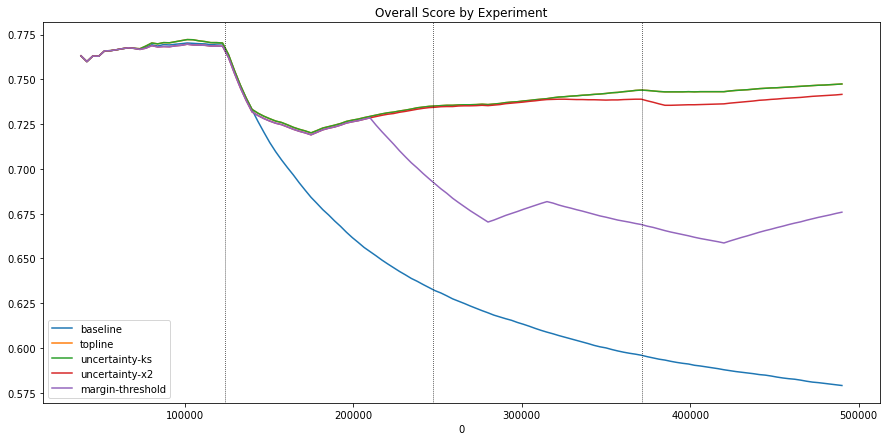

,drifts_signaled,actual_drift_occurences,false_positives,false_negatives,percent_total_labels,cumulative_accuracy,total_train_time
experiment,,,,,,,
baseline,0,0,0,0,0.0707,0.5790,0.17
topline,13,3,10,0,0.9896,0.7474,2.36
uncertainty-ks,13,3,10,0,0.9896,0.7474,2.44
uncertainty-x2,9,10,0,1,0.7069,0.7416,1.81
margin-threshold,5,11,0,6,0.4241,0.6758,1.09


<IPython.core.display.Javascript object>

In [65]:
# most to least severe, sensitivity = 1
exps = [baseline, topline, uncertainty_ks, uncertainty_x2, margin_threshold]
plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

### Experiment with Window Sizes

In [9]:
multiple_exp_log = []
for multiple in [1, 2, 3, 4]:

    column_mapping = {
        "target": "cover_type",
        "numerical_features": [col for col, iscat in col_names if not iscat],
        "categorical_features": [col for col, iscat in col_names if iscat][:-1],
    }

    # 17500
    CT_dataset = Dataset(
        full_df=drift_df, column_mapping=column_mapping, window_size=17500 * multiple
    )

    model = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
    param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

    baseline = BaselineExperiment(
        model=model, dataset=CT_dataset, param_grid=param_grid
    )
    baseline.run()

    topline = ToplineExperiment(
        model=model, dataset=CT_dataset, param_grid=param_grid, k=10
    )
    topline.run()

    uncertainty_ks = UncertaintyKSExperiment(
        model=model,
        dataset=CT_dataset,
        param_grid=param_grid,
        k=10,
        significance_thresh=0.001,
    )
    uncertainty_ks.run()

    uncertainty_x2 = UncertaintyX2Experiment(
        model=model,
        dataset=CT_dataset,
        param_grid=param_grid,
        k=10,
        significance_thresh=0.001,
        margin_width=0.1,
    )
    uncertainty_x2.run()

    margin_threshold = MarginThresholdExperiment(
        model=model,
        dataset=CT_dataset,
        param_grid=param_grid,
        k=10,
        margin_width=0.1,
        sensitivity=1,
    )
    margin_threshold.run()

    exps = [baseline, topline, uncertainty_ks, uncertainty_x2, margin_threshold]
    multiple_exp_log.append(exps)
#     plot_multiple_experiments(exps, change_points)
#     aggregate_experiment_metrics(exps)

GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 1
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 2
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 3
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 4
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 5
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 6
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 7
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_st

GETTING REFERENCE DISTRIBUTION FOR WINDOW: 7
FINAL SHAPE kfold preds: (17500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 8
Dataset Split: 8
REFERENCE STATS: DescribeResult(nobs=17500, minmax=(0.11187212794030668, 0.893008748934071), mean=0.5704752710012804, variance=0.023265625999642162, skewness=-0.3368857905295195, kurtosis=-1.011719798842394)
DETECTION STATS: DescribeResult(nobs=17500, minmax=(0.11407841485176821, 0.9191725130473799), mean=0.5681785379687675, variance=0.018823688811409795, skewness=-0.2812529443786327, kurtosis=-0.9626759925541033)
KS Test Result: FAILED | KstestResult(statistic=0.07891428571428571, pvalue=7.654914163527357e-48)

Dataset index of split end: 175000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 8
FINAL SHAPE kfold preds: (17500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 9
Dataset Split: 9
REFERENCE STATS: DescribeResult(nobs=17500, minmax=(0.08561081055106859, 0.9570495356783384), mean=0.5760063665101587, variance=0.029059346426794423, skewness=-0.231

KS Test Result: FAILED | KstestResult(statistic=0.0609142857142857, pvalue=1.1482595566039724e-28)

Dataset index of split end: 367500
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 19
FINAL SHAPE kfold preds: (17500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 20
Dataset Split: 20
REFERENCE STATS: DescribeResult(nobs=17500, minmax=(0.09660792500712251, 0.959189030850295), mean=0.565076002280599, variance=0.02956317919153074, skewness=-0.16409689301751967, kurtosis=-1.173099408962513)
DETECTION STATS: DescribeResult(nobs=17500, minmax=(0.09565739413015995, 0.9117528065861643), mean=0.566381788624608, variance=0.023344573936340773, skewness=-0.13364131364416704, kurtosis=-0.9402298913512026)
KS Test Result: FAILED | KstestResult(statistic=0.08851428571428571, pvalue=4.2386636640153033e-60)

Dataset index of split end: 385000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 20
FINAL SHAPE kfold preds: (17500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 21
Dataset Split: 21
REFERENCE STATS: Describ

GETTING REFERENCE DISTRIBUTION FOR WINDOW: 7
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 10
X2 Test Result: FAILED | Power_divergenceResult(statistic=117.38007081415101, pvalue=2.3700643369506356e-27)

Dataset index of split end: 210000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 8
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 11
X2 Test Result: FAILED | Power_divergenceResult(statistic=133.63435948894315, pvalue=6.5683657582790015e-31)

Dataset index of split end: 227500
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 9
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 12
X2 Test Result: FAILED | Power_divergenceResult(statistic=146.36190765870384, pvalue=1.0819903609056347e-33)

Dataset index of split end: 245000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 10
SEL

GETTING DETECTION DISTRIBUTION FOR WINDOW: 12
Significant Change in Margin Density: False
Change in MD: 0.0031428571428571417
Sensitivity: 1 | Ref_SD: 0.012944591495276775 | Threshold: 0.012944591495276775

Dataset index of split end: 245000
GETTING DETECTION DISTRIBUTION FOR WINDOW: 13
Significant Change in Margin Density: False
Change in MD: 0.008400000000000005
Sensitivity: 1 | Ref_SD: 0.012944591495276775 | Threshold: 0.012944591495276775

Dataset index of split end: 262500
GETTING DETECTION DISTRIBUTION FOR WINDOW: 14
Significant Change in Margin Density: False
Change in MD: 0.007085714285714292
Sensitivity: 1 | Ref_SD: 0.012944591495276775 | Threshold: 0.012944591495276775

Dataset index of split end: 280000
GETTING DETECTION DISTRIBUTION FOR WINDOW: 15
Significant Change in Margin Density: False
Change in MD: 0.010171428571428574
Sensitivity: 1 | Ref_SD: 0.012944591495276775 | Threshold: 0.012944591495276775

Dataset index of split end: 297500
GETTING DETECTION DISTRIBUTION FOR 

KS Test Result: FAILED | KstestResult(statistic=0.05940000000000001, pvalue=4.0757639642383514e-54)

Dataset index of split end: 210000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 4
FINAL SHAPE kfold preds: (35000,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 5
Dataset Split: 5
REFERENCE STATS: DescribeResult(nobs=35000, minmax=(0.09964369605547822, 0.9158230067033568), mean=0.576838641529171, variance=0.026739022083988033, skewness=-0.2228904977294807, kurtosis=-1.143488154213829)
DETECTION STATS: DescribeResult(nobs=35000, minmax=(0.05905303660365583, 0.916131864892878), mean=0.5765985910451071, variance=0.02376596174728398, skewness=-0.2717076949007498, kurtosis=-0.842636632067761)
KS Test Result: FAILED | KstestResult(statistic=0.06311428571428579, pvalue=4.793918084800341e-61)

Dataset index of split end: 245000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 5
FINAL SHAPE kfold preds: (35000,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 6
Dataset Split: 6
REFERENCE STATS: DescribeResult(

GETTING REFERENCE DISTRIBUTION FOR WINDOW: 6
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 7
X2 Test Result: PASSED | Power_divergenceResult(statistic=1.7637410954053452, pvalue=0.1841585684090153)

Dataset index of split end: 315000
GETTING DETECTION DISTRIBUTION FOR WINDOW: 8
X2 Test Result: PASSED | Power_divergenceResult(statistic=8.098811152371482, pvalue=0.00442943018899944)

Dataset index of split end: 350000
GETTING DETECTION DISTRIBUTION FOR WINDOW: 9
X2 Test Result: PASSED | Power_divergenceResult(statistic=0.3062050512856502, pvalue=0.5800183079501269)

Dataset index of split end: 385000
GETTING DETECTION DISTRIBUTION FOR WINDOW: 10
X2 Test Result: FAILED | Power_divergenceResult(statistic=713.9202016138331, pvalue=2.8100042572149607e-157)

Dataset index of split end: 420000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 7
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)

KS Test Result: FAILED | KstestResult(statistic=0.1321904761904762, pvalue=0.0)

Dataset index of split end: 262500
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 3
FINAL SHAPE kfold preds: (52500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 4
Dataset Split: 4
REFERENCE STATS: DescribeResult(nobs=52500, minmax=(0.0644892461973399, 0.9458554495532099), mean=0.5742119174914113, variance=0.028727366508604083, skewness=-0.20400619026574274, kurtosis=-1.2021034308038492)
DETECTION STATS: DescribeResult(nobs=52500, minmax=(0.06663731673343651, 0.8981980417233728), mean=0.5672040174726991, variance=0.023693479395083195, skewness=-0.2743441680309857, kurtosis=-1.0091847315608224)
KS Test Result: FAILED | KstestResult(statistic=0.09209523809523812, pvalue=3.364660771827138e-194)

Dataset index of split end: 315000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 4
FINAL SHAPE kfold preds: (52500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 5
Dataset Split: 5
REFERENCE STATS: DescribeResult(nobs=52500, mi

GETTING DETECTION DISTRIBUTION FOR WINDOW: 8
Significant Change in Margin Density: True
Change in MD: 0.05003809523809524
Sensitivity: 1 | Ref_SD: 0.045708670290028564 | Threshold: 0.045708670290028564

GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 1
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 2
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 3
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 4
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 5
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
Dataset index of split end: 140000
GETTIN

GETTING DETECTION DISTRIBUTION FOR WINDOW: 6
Significant Change in Margin Density: False
Change in MD: 0.02260000000000001
Sensitivity: 1 | Ref_SD: 0.027071952501526334 | Threshold: 0.027071952501526334



<IPython.core.display.Javascript object>

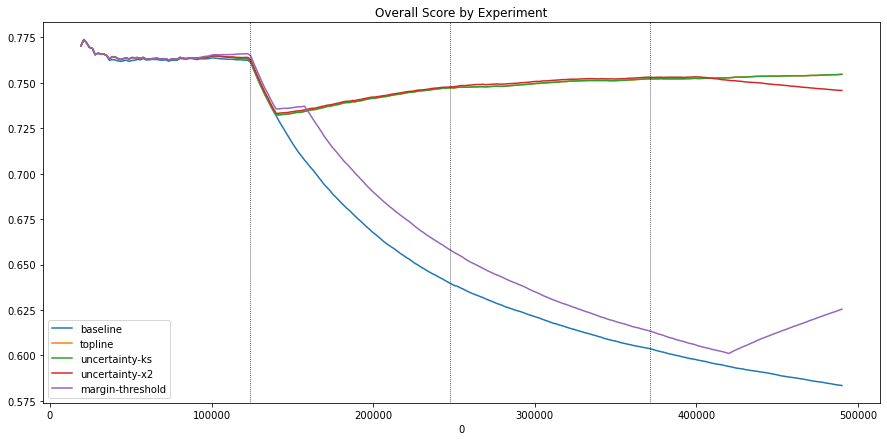

                  drifts_signaled  actual_drift_occurences  false_positives  \
experiment                                                                    
baseline                        0                        0                0   
topline                        27                        2               25   
uncertainty-ks                 27                        2               25   
uncertainty-x2                 18                       11               13   
margin-threshold                8                       21                3   

                  false_negatives  percent_total_labels  cumulative_accuracy  \
experiment                                                                     
baseline                        0                0.0353               0.5835   
topline                         0                0.9896               0.7546   
uncertainty-ks                  0                0.9896               0.7546   
uncertainty-x2                  6             

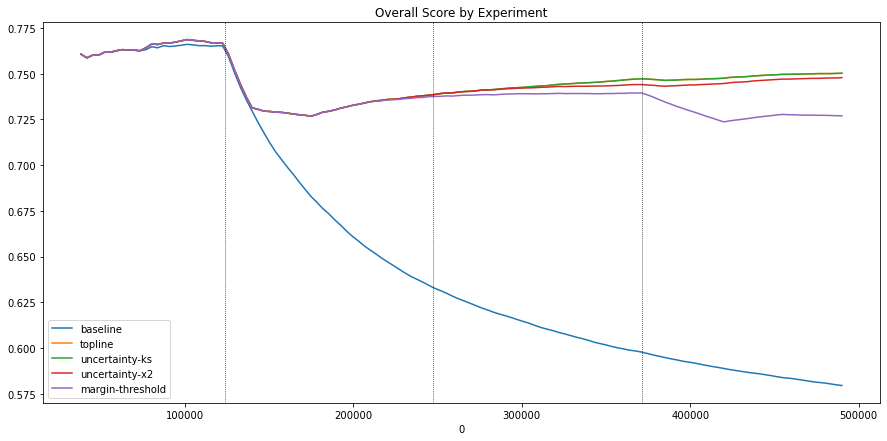

                  drifts_signaled  actual_drift_occurences  false_positives  \
experiment                                                                    
baseline                        0                        0                0   
topline                        13                        3               10   
uncertainty-ks                 13                        3               10   
uncertainty-x2                 10                        6                4   
margin-threshold                5                        6                2   

                  false_negatives  percent_total_labels  cumulative_accuracy  \
experiment                                                                     
baseline                        0                0.0707               0.5795   
topline                         0                0.9896               0.7502   
uncertainty-ks                  0                0.9896               0.7502   
uncertainty-x2                  0             

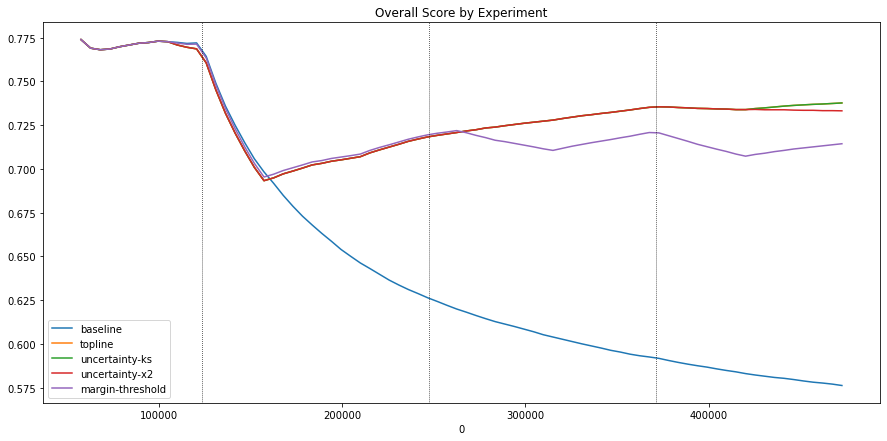

                  drifts_signaled  actual_drift_occurences  false_positives  \
experiment                                                                    
baseline                        0                        0                0   
topline                         8                        2                6   
uncertainty-ks                  8                        2                6   
uncertainty-x2                  6                        3                5   
margin-threshold                5                        7                0   

                  false_negatives  percent_total_labels  cumulative_accuracy  \
experiment                                                                     
baseline                        0                0.1060               0.5763   
topline                         0                0.9543               0.7377   
uncertainty-ks                  0                0.9543               0.7377   
uncertainty-x2                  2             

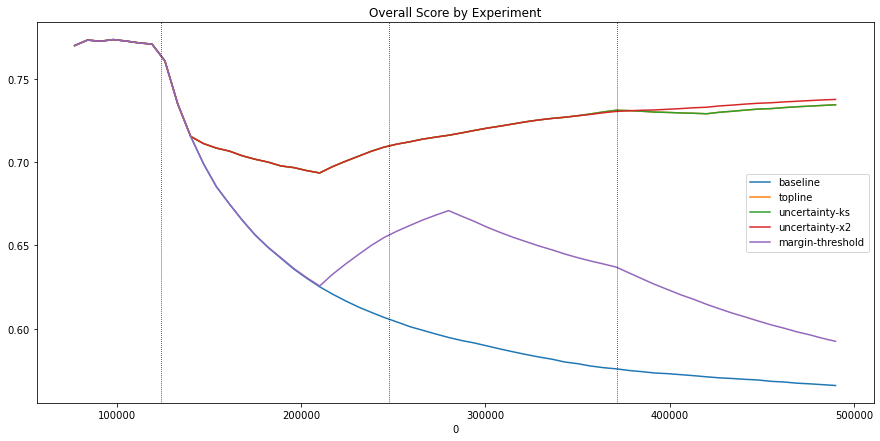

                  drifts_signaled  actual_drift_occurences  false_positives  \
experiment                                                                    
baseline                        0                        0                0   
topline                         6                        3                3   
uncertainty-ks                  6                        3                3   
uncertainty-x2                  5                        4                1   
margin-threshold                1                        6                0   

                  false_negatives  percent_total_labels  cumulative_accuracy  \
experiment                                                                     
baseline                        0                0.1414               0.5660   
topline                         0                0.9896               0.7344   
uncertainty-ks                  0                0.9896               0.7344   
uncertainty-x2                  0             

<IPython.core.display.Javascript object>

In [10]:
for log in multiple_exp_log:
    plot_multiple_experiments(log, change_points)
    print(aggregate_experiment_metrics(log))

In [ ]:
# window x1
exps = [baseline, topline, uncertainty_ks, uncertainty_x2]
plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

In [ ]:
# window x2
exps = [baseline, topline, uncertainty_ks, uncertainty_x2]
plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

In [ ]:
# window x3
exps = [baseline, topline, uncertainty_ks, uncertainty_x2]
plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

### Uncertainty KS Debug

In [ ]:
plot_experiment_error(uncertainty_ks)

In [ ]:
plot_response_distributions_bysplit(uncertainty_ks)

### Margin Uncertainty Debug

In [ ]:
plot_margin_distributions_bysplit(uncertainty_x2)

## KS Test Deep Dive

### What is minimum reference window size for passing KS test?

Let's see what window size is needed to pass a KS test on the original dataset that has NO drift in it.

In [ ]:
with open("../data/covtype_nodrift_norm.pkl", "rb") as f:
    nodrift_df = pickle.load(f)

nodrift_df = nodrift_df.reset_index(drop=True)

In [ ]:
CT_nodrift_dataset = Dataset(
    full_df=nodrift_df, column_mapping=column_mapping, window_size=17500 * 5
)

uncertainty_ks_nodrift = UncertaintyKSExperiment(
    model=model,
    dataset=CT_nodrift_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
)
uncertainty_ks_nodrift.run()

In [ ]:
plot_response_distributions_bysplit(uncertainty_ks_nodrift)

**It looks like Kologorov-Smirnov is too sensitive/strict for our use case**

"A test has told you that two samples aren't from literally identical populations, but that's not what you actually care about. What you actually care about is up to you; it sounds like you care about how different the populations are. The solution is not to try to transform 𝑝-values ("when all you have is a hammer", etc.) but to use a more appropriate technique."

Even with the non-drifting dataset and huge windows, KS tests are too sensitive.

### Distance Metrics instead of KS test?

Maybe we could try calculating a distance instead of applying a check yes-no hypothesis test. The drawback here is that using distances requires us to then tune a threshold that indicates what level of distance is deemed acceptable - another hyperparameter to tune

In [ ]:
calculate_split_window_distances(sqsi_mr, scipy.stats.entropy)

In [ ]:
calculate_distances_window_distances(sqsi_mr, scipy.stats.wasserstein_distance)

In [ ]:
calculate_distances_window_distances(sqsi_mr, scipy.spatial.distance.jensenshannon)

## Margin Uncertainty Approach with Chi-Squared Test

In [ ]:
CT_nodrift_dataset = Dataset(
    full_df=nodrift_df, column_mapping=column_mapping, window_size=17500 * 3
)

uncertainty_x2_nodrift = UncertaintyX2Experiment(
    model=model,
    dataset=CT_nodrift_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
    margin_width=0.1,
)
uncertainty_x2_nodrift.run()

In [ ]:
plot_margin_distributions_bysplit(uncertainty_x2_nodrift)

- Null Hypothesis (H0): Observed data follow the expected distribution
- Alternative Hypothesis (HA): Observed data do NOT follow the expected distribution
    
If p_value is less than 0.05, reject null hypothesis --> They are from different distributions

## Margin Uncertainty Approach with Sensitivity Threshold

In [ ]:
CT_dataset = Dataset(
    full_df=drift_df, column_mapping=column_mapping, window_size=17500 * 2
)

margin_threshold_dev = MarginThresholdExperiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    margin_width=0.1,
    sensitivity=1,
)
margin_threshold_dev.run()

In [ ]:
margin_threshold_dev.drift_signals

In [ ]:
margin_threshold_dev.drift_occurences

In [ ]:
margin_threshold_dev.false_negatives

In [ ]:
margin_threshold_dev.density_changes

In [ ]:
margin_threshold_dev.accuracy_changes

In [ ]:
for i in range(len(margin_threshold_dev.accuracy_changes)):

    drift_signaled_flag = True if margin_threshold_dev.density_changes[i] else False
    drift_occured_flag = True if margin_threshold_dev.accuracy_changes[i] else False
    fp_flag = (
        True
        if margin_threshold_dev.density_changes[i]
        and not margin_threshold_dev.accuracy_changes[i]
        else False
    )
    fn_flag = (
        True
        if not margin_threshold_dev.density_changes[i]
        and margin_threshold_dev.accuracy_changes[i]
        else False
    )

    print(i)

    if drift_signaled_flag:
        print("Drift Detection Signaled")

    if drift_occured_flag:
        print("Actual Drift Occured")

    if fp_flag:
        print("FALSE POSITIVE")

    if fn_flag:
        print("FALSE NEGATIVE")

    print()

In [ ]:
[True if margin_threshold_dev.density_changes[i] else False for i in margin_threshold_dev.density_changes]

In [ ]:
margin_threshold_dev.density_changes

In [ ]:
sum([True if margin_threshold_dev.density_changes[i] and not margin_threshold_dev.accuracy_changes[i] else False for i in range(len(margin_threshold_dev.density_changes))])



In [ ]:
    drift_signaled_flag = True if margin_threshold_dev.density_changes[i] else False
    drift_occured_flag = True if margin_threshold_dev.accuracy_changes[i] else False

In [ ]:

    sum([
        True if margin_threshold_dev.accuracy_changes[i] else False
        for i in range(len(margin_threshold_dev.density_changes))
    ])


In [ ]:
# keep
drifts_signaled = sum(
    [
        True if margin_threshold_dev.density_changes[i] else False
        for i in range(len(margin_threshold_dev.density_changes))
    ]
)
drifts_occured =     sum([
        True if margin_threshold_dev.accuracy_changes[i] else False
        for i in range(len(margin_threshold_dev.density_changes))
    ])
false_positives = sum([True if margin_threshold_dev.density_changes[i] and not margin_threshold_dev.accuracy_changes[i] else False for i in range(len(margin_threshold_dev.density_changes))])
false_negatives = sum([True if not margin_threshold_dev.density_changes[i] and margin_threshold_dev.accuracy_changes[i] else False for i in range(len(margin_threshold_dev.density_changes))])


In [ ]:
for pair in list(
    zip(
        margin_threshold_dev.ref_ACCs,
        [acc_sd * 3 for acc_sd in margin_threshold_dev.ref_ACC_SDs],
        margin_threshold_dev.det_ACCs,
    )
):
    print(pair)

In [ ]:
margin_threshold_dev.det_ACCs

In [ ]:
margin_threshold_dev.split_ACCs

In [ ]:
margin_threshold.ref_distributions[0].shape

In [ ]:
ypred = margin_threshold.ref_distributions[0]

In [ ]:
_, ytrue = margin_threshold.dataset.get_data_by_idx(0, 35000)

In [ ]:
ytrue

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
type(ypred)

In [ ]:
ypred.dtype

In [ ]:
ytrue.dtype

In [ ]:
type(ytrue.to_numpy())

In [ ]:
accuracy_score(ytrue.to_numpy(), ypred)

In [ ]:
margin_threshold_dev.ref_MDs

In [ ]:
margin_threshold_dev.det_MDs

In [ ]:
margin_threshold_dev.ref_SDs

In [ ]:
scipy.stats.describe(margin_threshold_dev.split_MDs)

In [ ]:
np.mean(margin_threshold_dev.split_MDs)

In [ ]:
np.std(margin_threshold_dev.split_MDs)

In [ ]:
margin_threshold_dev.ref_margins[0]

In [ ]:
pd.Series(
    margin_threshold_dev.ref_margins[0] < margin_threshold_dev.margin_width
).astype(int).value_counts(normalize=True)[1]

#### split accuracy